In [1]:
!git clone https://github.com/PuiPu/data_sci_final_project.git

Cloning into 'data_sci_final_project'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 623.96 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (11/11), done.


# Step 0: Explore the dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10080 entries, 1984-09-07 to 2024-09-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10080 non-null  float64
dtypes: float64(1)
memory usage: 157.5 KB


<Axes: xlabel='Date'>

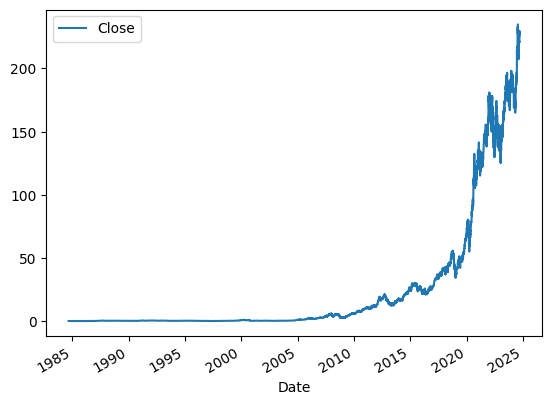

In [24]:
import pandas as pd
df = pd.read_csv('/content/data_sci_final_project/aapl_us_d.csv')

# select only 'Close' column
df = df.loc[:, ['Date', 'Close']]
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index) # make sure index is datetime format

df.info()
df.plot()

<Axes: xlabel='Date'>

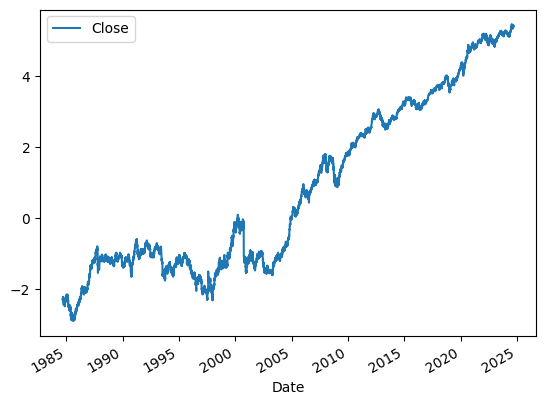

In [25]:
import numpy as np
close_df = pd.DataFrame(df['Close'])
close_df = np.log(close_df) # don't forget to transform the data back when making real predictions

close_df.plot()

1. 取 log 有讓 data less variant

In [26]:
# split data
df_train = df[:'2014-11-6']
test_data = df['2014-11-7':] # 先用到2023，照理講應該要到2024(總共14年)

# Step 1: Check for stationarity of time series

## Method #1: time series plot

## Method #2: ACF plot and PACF plot
1. ACF(autocorrelation function)
2. PACF(partial autocorrelation function)

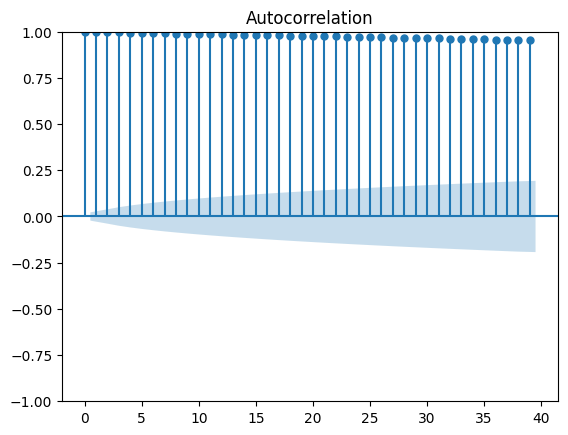

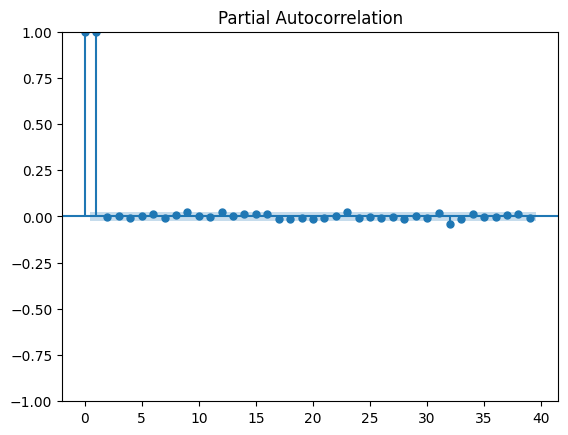

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## Method #3: ADF test
1. test for stationary
2. p-value = 1，代表非常不穩定，有可能是 random



In [28]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 1.0


close log & diff p-value: 0.0


<Axes: xlabel='Date'>

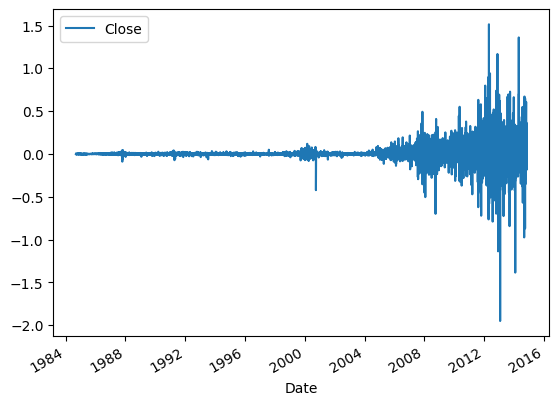

In [33]:
close_df_diff = close_df.diff().dropna()
close_adf_test = adfuller(close_df_diff)
print(f'close log & diff p-value: {close_adf_test[1]}') # p-val = 0 代表是平穩的
df_diff.plot()

<Axes: xlabel='Date'>

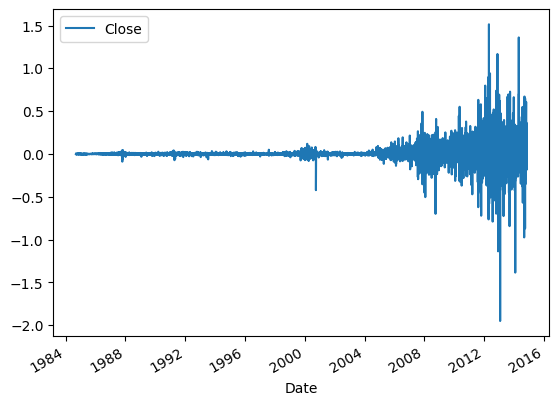

In [29]:
df_diff = df_train.diff().dropna()
df_diff.plot()

## Transform to stationary: differencing

<Axes: xlabel='Date'>

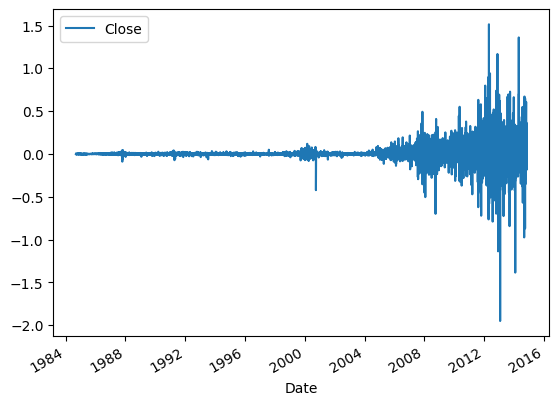

In [34]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

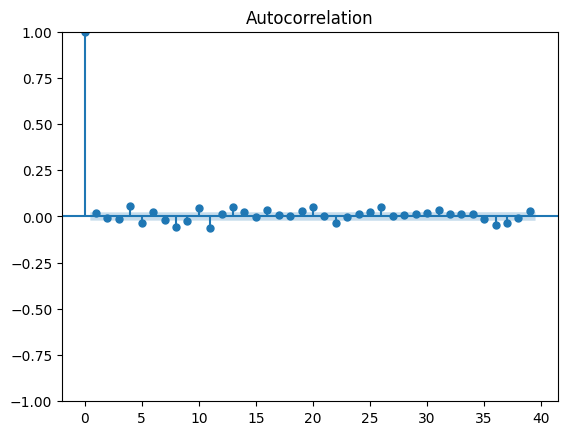

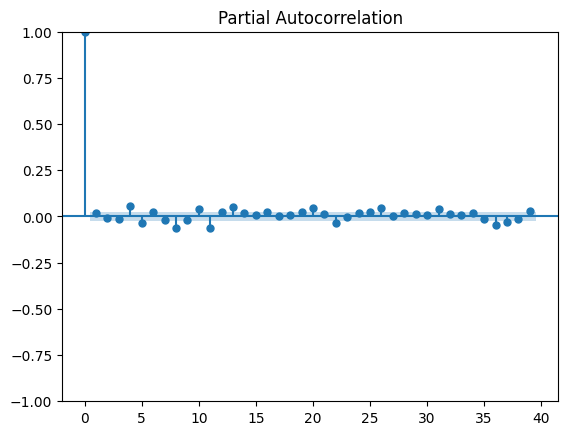

In [35]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

根據經驗法則：

1. 如果 ACF 在 lag=1 處顯著，而 PACF 在 lag=1 處也顯著，則可以考慮 ARIMA(1, d, 1) 模型。
2. 如果 ACF 在 lag=1 處顯著，而 PACF 在 lag=1, 2 處都顯著，則可以考慮 ARIMA(2, d, 1) 模型。
3. 如果 ACF 在 lag=1, 2 處都顯著，而 PACF 在 lag=1 處顯著，則可以考慮 ARIMA(1, d, 2) 模型。

In [36]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 1.7547341310993875e-22


# Step 2: Determine ARIMA models parameters p, q

# Step 3: Fit the ARIMA model

In [37]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 7607
Model:                 ARIMA(1, 2, 1)   Log Likelihood                6403.350
Date:                Mon, 25 Nov 2024   AIC                         -12800.699
Time:                        10:38:21   BIC                         -12779.890
Sample:                             0   HQIC                        -12793.558
                               - 7607                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0157      0.004      3.560      0.000       0.007       0.024
ma.L1         -0.9987      0.000  -2893.951      0.000      -0.999      -0.998
sigma2         0.0109   3.61e-05    300.882      0.0

# Step 4: Make time series predictions

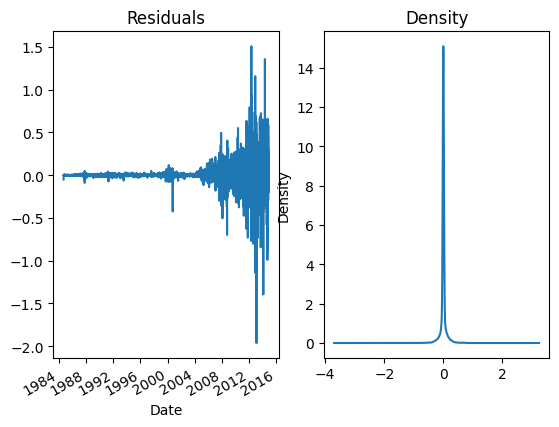

In [38]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

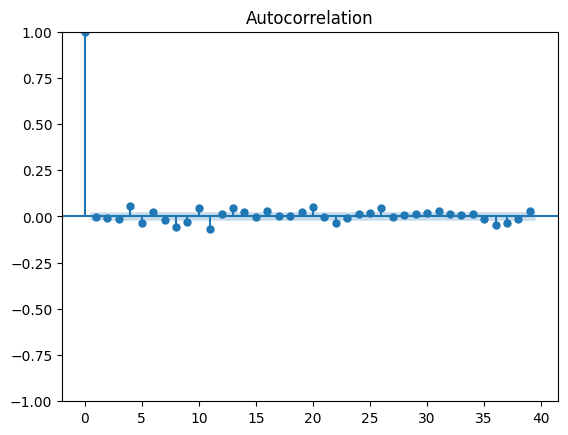

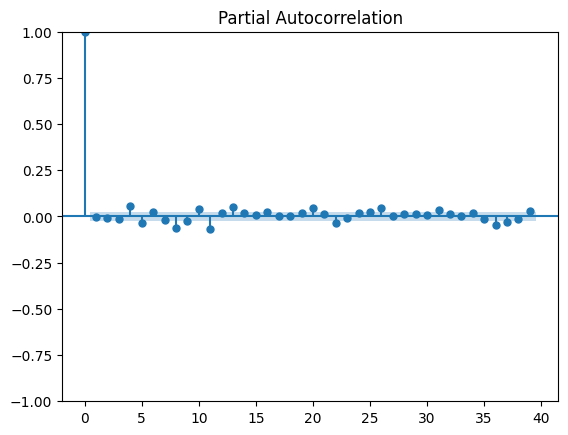

In [39]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date'>

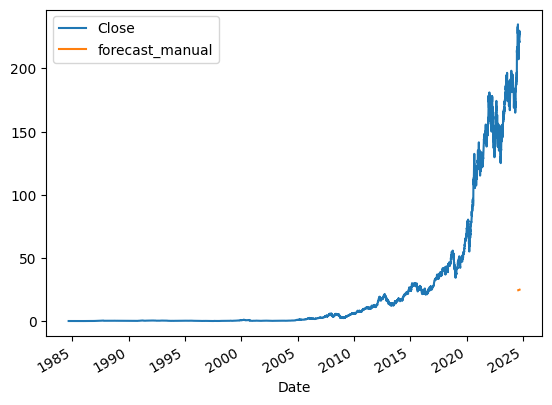

In [41]:
forecast_test = model_fit.forecast(len(df_test))

# Calculate the difference between your data frame and your train and test split
diff = len(df) - (len(df_train) + len(df_test))

df['forecast_manual'] = [None]*(len(df_train) + diff) + list(forecast_test)

df.plot()

# Optional: Auto-fit the ARIMA model

In [43]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00


In [44]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 2, 4), scoring_args={}, suppress_warnings=True)

In [45]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7607
Model:               SARIMAX(0, 2, 4)   Log Likelihood                6380.942
Date:                Mon, 25 Nov 2024   AIC                         -12749.884
Time:                        10:53:21   BIC                         -12708.265
Sample:                             0   HQIC                        -12735.603
                               - 7607                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.218e-06   1.89e-05      0.065      0.949   -3.58e-05    3.82e-05
ma.L1         -0.9910      0.004   -223.263      0.000      -1.000      -0.982
ma.L2         -0.0497      0.006     -7.752      0.000      -0.062      -0.037
ma.L3          0.0502      0.006      8.169      0.000       0.038       0.062
ma.L4          0.0057      0.004      1.298      0.194      -0.003       0.014
sigma2         0.0109   3.76e-05    290.367      0.000       0.011       0.011
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):            672710.41
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):             483.58   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 5: Evaluate model predictions

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date'>

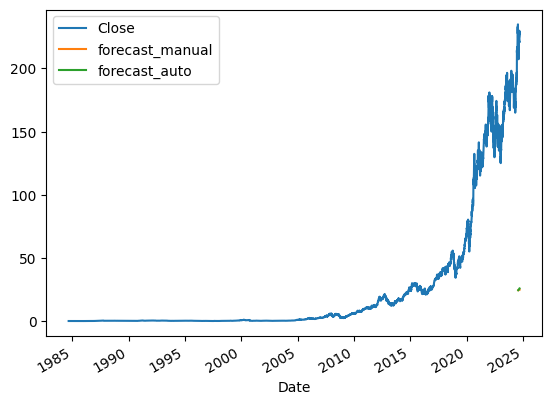

In [47]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))

# Calculate the difference between your data frame and your train and test split
diff = len(df) - (len(df_train) + len(df_test))

df['forecast_auto'] = [None]*(len(df_train) + diff) + list(forecast_test_auto)

df.plot()

In [48]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 19.284396445736427
mape - manual: 3.5716756882093126
rmse - manual: 19.284724066755306


In [49]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 19.780537120960187
mape - auto: 3.6634142005997266
rmse - auto: 19.7843649870723


# Other suggestions